## Image segmentation for Deepform

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path

In [4]:
path = Path()
path.ls()

[PosixPath('images.tar.gz'),
 PosixPath('masks'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('pages'),
 PosixPath('image_segmentation.ipynb')]

In [5]:
path_lbl = path/'masks'
path_img = path/'pages'

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('pages/435470-collect-files-73195-political-file-2012-federal_p01.png'),
 PosixPath('pages/432389-collect-files-59440-political-file-2012-federal_p01.png'),
 PosixPath('pages/424611-collect-files-73150-political-file-2012-federal_p01.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('masks/435470-collect-files-73195-political-file-2012-federal_p01.png'),
 PosixPath('masks/432389-collect-files-59440-political-file-2012-federal_p01.png'),
 PosixPath('masks/424611-collect-files-73150-political-file-2012-federal_p01.png')]

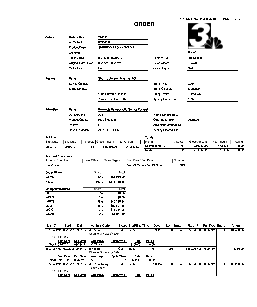

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.name}'

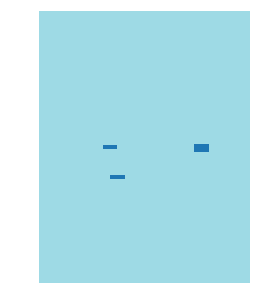

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data,mask.data.unique()

(array([1650, 1275]), tensor([[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]]), tensor([  0, 255]))

In [12]:
codes = np.array([f'Void{n:03}' for n in range(256)])
codes[0], codes[255] = 'GrossAmount', 'Document'
codes

array(['GrossAm', 'Void001', 'Void002', 'Void003', ..., 'Void252', 'Void253', 'Void254', 'Documen'], dtype='<U7')

In [13]:
mask.data.shape, img.data.shape

(torch.Size([1, 1650, 1275]), torch.Size([3, 1650, 1275]))

## Datasets

In [62]:
size = src_size//4

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 14455MB of GPU RAM free


In [18]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [63]:
data = (src.transform(get_transforms(do_flip=False, max_rotate=5., max_warp=0.1), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

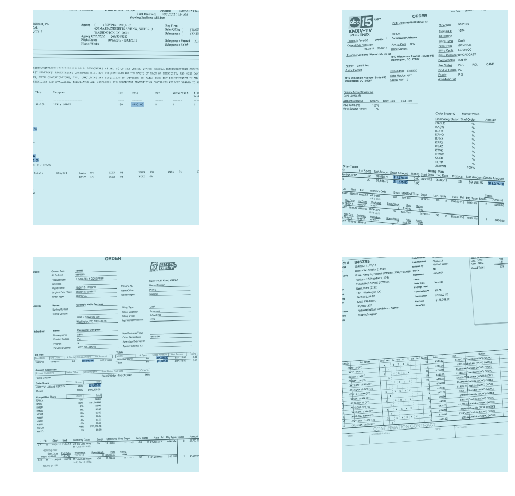

In [20]:
data.show_batch(2, figsize=(10,7))

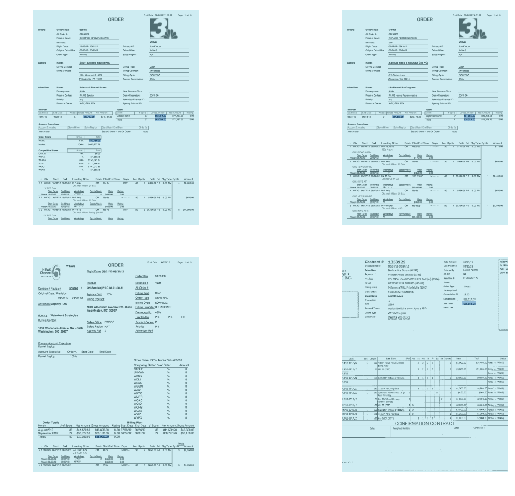

In [21]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [79]:
name2id = {v:k for k,v in enumerate(codes)}

def doc_acc(input, target):
    target = target.squeeze(1)
    if not (target == 0).any():
        # There is no answer on this page.
        wrong = (input.argmax(dim=1) == 0).float().mean()
        return 1 - np.pow(wrong, 0.25)
    mask = target == 0
    sensitivity = (input.argmax(dim=1)[mask] == 0).float().sum() / mask.float().sum()
    specificity = (input.argmax(dim=1)[~mask] == 1).float().sum() / (~mask).float().sum()
    return sensitivity * specificity

In [65]:
metrics=doc_acc

In [24]:
wd=1e-2

In [66]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,doc_acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


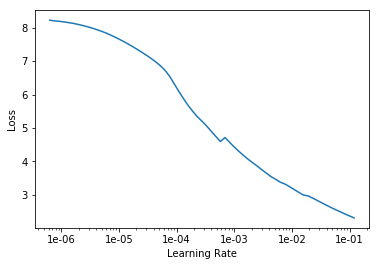

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lr=1e-2

In [28]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,doc_acc,time
0,0.038215,0.016252,0.997404,09:02
1,0.014022,0.014635,0.997404,08:59
2,0.013848,0.013778,0.997401,08:59


In [29]:
learn.save('stage-1')

In [30]:
learn.load('stage-1');

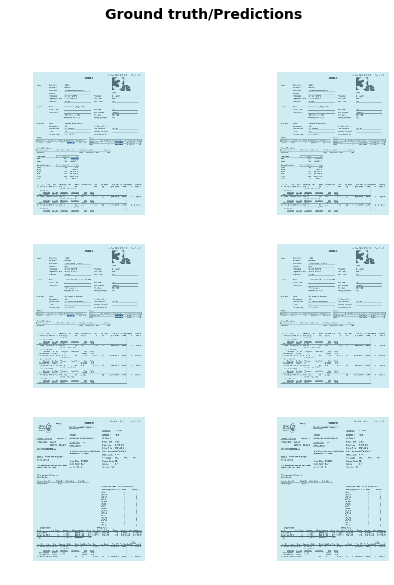

In [32]:
learn.show_results(rows=3, figsize=(8,9))

In [33]:
learn.unfreeze()

In [34]:
lrs = slice(lr/400,lr/4)

In [35]:
learn.fit_one_cycle(4, lrs, pct_start=0.4)

epoch,train_loss,valid_loss,doc_acc,time
0,0.015328,0.013591,0.997404,09:17
1,0.016656,0.014036,0.997397,09:17
2,0.014641,0.012865,0.997407,09:17
3,0.013101,0.012594,0.997411,09:18


In [36]:
learn.save('stage-2');

In [68]:
learn.load('stage-2');

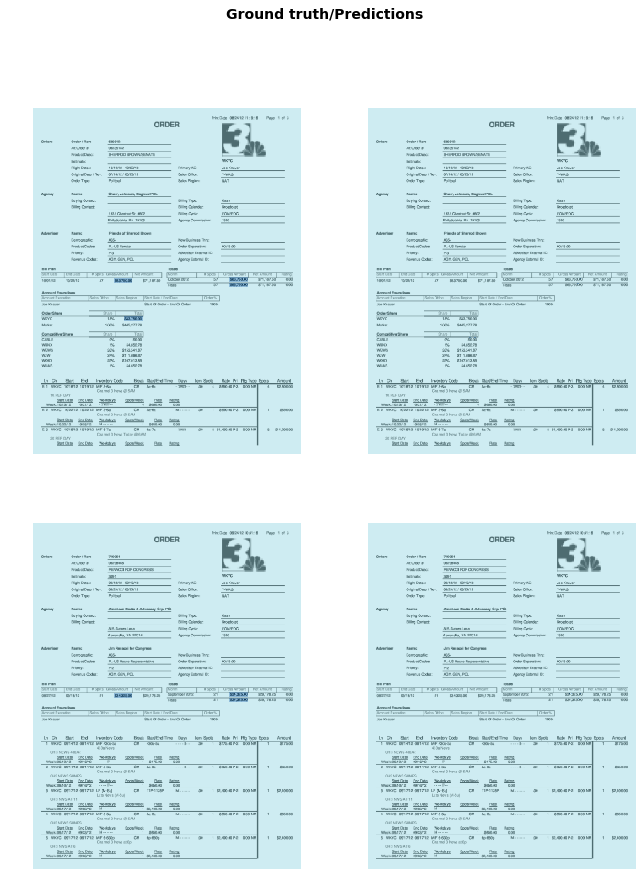

In [76]:
learn.show_results(rows=2, figsize=(11, 14))

In [77]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, lrs, pct_start=0.6)

epoch,train_loss,valid_loss,doc_acc,time
